## Tutorial - Comparing explanation methods

This tutorial demonstrates how to use the library to compare different explanations method with several different evaluation criteria. We use a LeNet model and CIFAR-10 dataset to showcase the library's functionality.



In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install captum
!pip install opencv-python
!pip install torch==1.8.0 torchvision==0.9.0	
#pip install torch==1.9.0+cu102 torchvision==0.9.1

import torch
import torchvision
from torchvision import transforms
import numpy as np
import pandas as pd
from tqdm import tqdm
from captum.attr import *
import matplotlib.pyplot as plt
from pathlib import Path
import warnings

# Retrieve source code.
from drive.MyDrive.Projects.xai_quantification_toolbox import * #import xaiquantificationtoolbox

# Notebook settings.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings("ignore", category=UserWarning)
%load_ext autoreload
%autoreload 2

#import gc
#gc.collect()
#torch.cuda.empty_cache()

     |████████████████████████████████| 1.4 MB 13.8 MB/s 
     |████████████████████████████████| 735.5 MB 13 kB/s 
     |████████████████████████████████| 17.3 MB 40 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.8.0 which is incompatible.


### Load CIFAR10 dataset.

In [3]:
# Load datasets and make loaders.
transformer = torchvision.transforms.ToTensor()
train_set = torchvision.datasets.CIFAR10(root='./sample_data', train=True, transform=transformer, download=True)
test_set = torchvision.datasets.CIFAR10(root='./sample_data', train=False, transform=transformer, download=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, pin_memory=True) # num_workers=4,
test_loader = torch.utils.data.DataLoader(test_set, batch_size=12, pin_memory=True)

# Load a batch of inputs and outputs to use for evaluation.
x_batch, y_batch = iter(test_loader).next()
x_batch, y_batch = x_batch.to(device), y_batch.to(device)


Extracting ./sample_data/cifar-10-python.tar.gz to ./sample_data
Files already downloaded and verified


### Train a LeNet model.

(or any other model of choice). Network architecture and training procedure is partly copied from: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py.

In [4]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = torch.nn.Conv2d(3, 6, 5)
        self.pool_1 = torch.nn.MaxPool2d(2, 2)
        self.pool_2 = torch.nn.MaxPool2d(2, 2)
        self.conv_2 = torch.nn.Conv2d(6, 16, 5)
        self.fc_1 = torch.nn.Linear(16 * 5 * 5, 120)
        self.fc_2 = torch.nn.Linear(120, 84)
        self.fc_3 = torch.nn.Linear(84, 10)
        self.relu_1 = torch.nn.ReLU()
        self.relu_2 = torch.nn.ReLU()
        self.relu_3 = torch.nn.ReLU()
        self.relu_4 = torch.nn.ReLU()

    def forward(self, x):
        x = self.pool_1(self.relu_1(self.conv_1(x)))
        x = self.pool_2(self.relu_2(self.conv_2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu_3(self.fc_1(x))
        x = self.relu_4(self.fc_2(x))
        x = self.fc_3(x)
        return x


# Load model architecture.
model = Net()
print(f"\n Model architecture: {model.eval()}\n")


 Model architecture: Net(
  (conv_1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc_1): Linear(in_features=400, out_features=120, bias=True)
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (fc_3): Linear(in_features=84, out_features=10, bias=True)
  (relu_1): ReLU()
  (relu_2): ReLU()
  (relu_3): ReLU()
  (relu_4): ReLU()
)



In [5]:
def train_model(model, 
                data: torchvision.datasets, 
                device: torch.device, 
                epochs: int = 20,
                criterion: torch.nn = torch.nn.CrossEntropyLoss(), 
                optimizer: torch.optim =torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9), 
                evaluate: bool = False):
    """Train torch model."""
    
    model.train()
    
    for epoch in range(epochs):
        for images, labels in data:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)

            loss = criterion(logits, labels)
            model.zero_grad()
            loss.backward()
            optimizer.step()

            # Evaluate model!
            predictions, labels = evaluate_model(model, data, device)
            test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())
            print(f"Epoch {epoch+1}/{epochs} - train accuracy: {(100 * test_acc):.2f}%")

    return model

def evaluate_model(model, data, device):
    """Evaluate torch model."""
    model.eval()
    logits = torch.Tensor().to(device)
    targets = torch.LongTensor().to(device)

    with torch.no_grad():
        for images, labels in data:
            images, labels = images.to(device), labels.to(device)
            logits = torch.cat([logits, model(images)])
            targets = torch.cat([targets, labels])
    
    return torch.nn.functional.softmax(logits, dim=1), targets

In [6]:
path_model_weights = "drive/MyDrive/Projects/xai_quantification_toolbox/nbs/resources/cifar10"

if Path(path_model_weights).is_file():
    model.load_state_dict(torch.load(path_model_weights))
else:
    
    # Train and evaluate model.
    model = train_model(model=model.to(device),
                        data=train_loader,
                        device=device,
                        epochs=20,
                        criterion=torch.nn.CrossEntropyLoss().to(device),
                        optimizer=torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9),
                        evaluate=True)
    
    # Save model.
    torch.save(model.state_dict(), path_model_weights)

print(f"Model loaded.")
model.eval()
model.to(device)

Model loaded.


Net(
  (conv_1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc_1): Linear(in_features=400, out_features=120, bias=True)
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (fc_3): Linear(in_features=84, out_features=10, bias=True)
  (relu_1): ReLU()
  (relu_2): ReLU()
  (relu_3): ReLU()
  (relu_4): ReLU()
)

### Load gradient-based attributions.

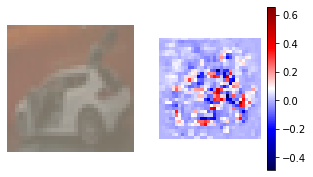

In [7]:
# Load attributions and plot them. 
a_batch = explain(model, 
                  x_batch, 
                  y_batch, 
                  explanation_func="IntegratedGradients",
                  **{"normalize": True})

# Plot examplary explanations!
index = random.randint(0, len(x_batch)-1)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
axes[0].imshow(denormalize_image(x_batch[index].cpu(), **{"img_size": 32}).transpose(0, 1).transpose(1, 2))
exp = axes[1].imshow(a_batch[index], cmap="seismic"); fig.colorbar(exp)
axes[0].axis("off"); axes[1].axis("off"); plt.show()

### Compare gradient-based explanation methods.

In [8]:
# Specify XAI methods.
methods = ["Gradient", "InputXGradient", "Saliency", "GradientShap"]

# Specify tests and set sensible hyperparameters.
measures = {"Faithfulness correlation": FaithfulnessCorrelation(**{"subset_size": 32}),
            "max-Sensitivity": MaxSensitivity(),
            "Infidelity": Infidelity(**{"perturb_patch_sizes": list(np.arange(2, 8)),
                                        "img_size": 32, 
                                        "nr_channels": 3})}
 
# Evaluate explanations!
results = {
    method: {measure: np.mean(func(model=model, 
                                   x_batch=x_batch.cpu().numpy(), 
                                   y_batch=y_batch.cpu().numpy(), 
                                   a_batch=None,
                                   **{"explanation_func": method, 
                                       "device": device,
                                       "img_size": 32,
                                       "normalize": True})) 
    for measure, func in measures.items()}
    for method in methods
}

# Summarise in a dataframe.      
df = pd.DataFrame(results)
df

,Gradient,InputXGradient,Saliency,GradientShap
Faithfulness correlation,0.017889,-0.012932,-0.010524,0.159567
max-Sensitivity,0.174043,0.158043,0.158957,0.198542
Infidelity,1.462801,1.604128,2.104775,1.207405
